In [219]:
# essential libraries
import random
from datetime import timedelta  

# storing and anaysis
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import calmap
import folium

# color pallette
cnf, dth, rec, act = '#393e46', '#ff2e63', '#21bf73', '#fe9801' 

# converter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()   

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# html embedding
from IPython.display import Javascript
from IPython.core.display import display
from IPython.core.display import HTML

config = {
  'toImageButtonOptions': {
    'format': 'svg', # one of png, svg, jpeg, webp
    'filename': '111',
#     'height': 1000,
#     'width':2000,
    'scale': 1 , # Multiply title/legend/axis/canvas sizes by this factor,
    'scrollZoom': True
  }
}

In [220]:
df = pd.read_csv('covid_19_clean_complete.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.head(6)

Province/State       Country/Region      Lat     Long       Date  Confirmed  \
0            NaN          Afghanistan  33.0000  65.0000 2020-01-22          0   
1            NaN              Albania  41.1533  20.1683 2020-01-22          0   
2            NaN              Algeria  28.0339   1.6596 2020-01-22          0   
3            NaN              Andorra  42.5063   1.5218 2020-01-22          0   
4            NaN               Angola -11.2027  17.8739 2020-01-22          0   
5            NaN  Antigua and Barbuda  17.0608 -61.7964 2020-01-22          0   

   Deaths  Recovered  
0       0          0  
1       0          0  
2       0          0  
3       0          0  
4       0          0  
5       0          0

In [221]:
print(df.info())
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16055 entries, 0 to 16054
Data columns (total 8 columns):
Province/State    4875 non-null object
Country/Region    16055 non-null object
Lat               16055 non-null float64
Long              16055 non-null float64
Date              16055 non-null datetime64[ns]
Confirmed         16055 non-null int64
Deaths            16055 non-null int64
Recovered         16055 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 1003.5+ KB
None
Province/State    11180
Country/Region        0
Lat                   0
Long                  0
Date                  0
Confirmed             0
Deaths                0
Recovered             0
dtype: int64


## Data Cleaning

In [222]:
import pycountry_convert as pc

def continent(country):
    try:
        country_code = pc.country_name_to_country_alpha2(country, cn_name_format="default")
#     print(country_code)
        try:
            continent_name = pc.country_alpha2_to_continent_code(country_code)

        except:
            continent_name = "Unknown"
    except:
        continent_name = "Unknown"
    return continent_name


In [223]:
df_clean = df
df_clean["Province/State"].fillna("", inplace=True)
df_clean["Active"] = df_clean["Confirmed"]-df_clean["Recovered"]-df_clean["Deaths"]
df_clean["Active"] = df_clean["Active"].fillna(0)
df_clean["Recovered"] = df_clean["Recovered"].fillna(0)
df_clean["Deaths"] = df_clean["Deaths"].fillna(0)
df_clean.loc[df_clean['Country/Region'] == 'US', 'Country/Region'] = 'USA'
# df_clean.tail(20)

for i in range(len(df_clean)) : 
  df_clean.loc[i,"Continent"]=continent(df_clean.loc[i, "Country/Region"])

df_clean.loc[df_clean['Continent'] == 'AS', 'Continent'] = 'Asia'
df_clean.loc[df_clean['Continent'] == 'EU', 'Continent'] = 'Europe'
df_clean.loc[df_clean['Continent'] == 'AF', 'Continent'] = 'Africa'
df_clean.loc[df_clean['Continent'] == 'NA', 'Continent'] = 'North America'
df_clean.loc[df_clean['Continent'] == 'SA', 'Continent'] = 'South America'
df_clean.loc[df_clean['Continent'] == 'OC', 'Continent'] = 'Australia'


df_clean['New_ID'] = df_clean.index + 0

df_clean = df_clean.sort_values(by="Date")
df_clean['time']=df_clean.Date.apply(lambda x: x.date()).apply(str)



df_clean.head()

Province/State Country/Region      Lat      Long       Date  Confirmed  \
0                     Afghanistan  33.0000   65.0000 2020-01-22          0   
157                     Mauritius -20.2000   57.5000 2020-01-22          0   
158                        Mexico  23.6345 -102.5528 2020-01-22          0   
159                       Moldova  47.4116   28.3699 2020-01-22          0   
160                        Monaco  43.7333    7.4167 2020-01-22          0   

     Deaths  Recovered  Active      Continent  New_ID        time  
0         0          0       0           Asia       0  2020-01-22  
157       0          0       0         Africa     157  2020-01-22  
158       0          0       0  North America     158  2020-01-22  
159       0          0       0         Europe     159  2020-01-22  
160       0          0       0         Europe     160  2020-01-22

In [224]:
## Segregrate China and Outside China

In [225]:
# cases in the ships
ship = df_clean[df_clean['Province/State'].str.contains('Grand Princess')|df_clean['Country/Region'].str.contains('Diamond Princess')]

# china and the row
china = df_clean[df_clean['Country/Region']=='China']
row = df_clean[df_clean['Country/Region']!='China']

# latest
full_latest = df_clean[df_clean['Date'] == max(df_clean['Date'])].reset_index()
china_latest = full_latest[full_latest['Country/Region']=='China']
row_latest = full_latest[full_latest['Country/Region']!='China']

# latest condensed
full_latest_grouped = full_latest.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
china_latest_grouped = china_latest.groupby('Province/State')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
row_latest_grouped = row_latest.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()

In [226]:
df_group_by_country_date = df_clean.groupby(['Date','Country/Region'])['Confirmed','Recovered', 'Deaths', 'Active'].sum().reset_index()

In [227]:
## Latest data available till 26/03/2020

In [228]:
df_total = df_clean.groupby(['Country/Region', 'Province/State'])['Date','Confirmed', 'Deaths', 'Recovered', 'Active' ].max()
df_total['Date'].max()

Timestamp('2020-03-26 00:00:00')

In [229]:
## Total cases and Death Rate until 26-03-2020

In [230]:
total_cases = df_total['Confirmed'].sum()
total_deaths = df_total['Deaths'].sum()
total_recovered = df_total['Recovered'].sum()
date = df_total['Date'].max()
death_rate = (total_deaths/total_cases)*100
x = pd.DataFrame({'Date':date,'Total Confirmed':total_cases , 'Total Deaths': total_deaths, 'Total Recovered': total_recovered
             ,'Death Rate':death_rate}, index=[0])
x.head()

Date  Total Confirmed  Total Deaths  Total Recovered  Death Rate
0 2020-03-26           529607         23979           122033    4.527697

In [231]:
import plotly.graph_objects as go

labels = ['Total Confirmed Cases','Total Deaths','Total Recovered']
values = [total_cases, total_deaths, total_recovered]

# pull is given as a fraction of the pie radius
fig = go.Figure(data=[go.Pie(labels=labels, values=values, pull=[0, 0.2,0],textinfo='label+percent')])

fig.show()

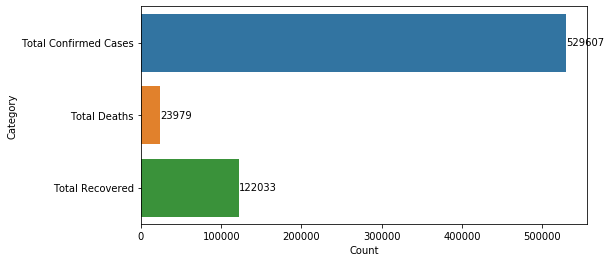

In [232]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()/2
                value = int(p.get_width())
                ax.text(_x, _y, value ,va="center", ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        

list1 = ['Total Confirmed Cases','Total Deaths','Total Recovered']
list2 = []
list2.append(int(total_cases))
list2.append(int(total_deaths))
list2.append(int(total_recovered))

df_temp = pd.DataFrame(list(zip(list1, list2)), 
               columns =['Category', 'Count']) 
plt.figure(figsize=(8, 4))
ax = sns.barplot(y="Category", x="Count", data=df_temp)
show_values_on_bars(ax, "h", 0.5)

In [233]:
## Cases, deaths and recoveries country wise

In [234]:
df_latest = df_clean[df_clean['Date'] == max(df_clean['Date'])].reset_index()
df_latest = df_latest.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()

stats = df_latest[['Country/Region','Confirmed', 'Active', 'Deaths', 'Recovered']]

stats = stats.sort_values(by='Confirmed', ascending=False)
stats = stats.reset_index(drop=True)

stats.style.background_gradient(cmap="Blues", subset=['Confirmed', 'Active'])\
            .background_gradient(cmap="Greens", subset=['Recovered'])\
            .background_gradient(cmap="Reds", subset=['Deaths'])

In [235]:
stats = stats.sort_values(by='Deaths', ascending=False).reset_index(drop=True)
stats['Death Rate %'] = (stats['Deaths']/stats['Confirmed'])*100
death_stats = stats[['Country/Region','Deaths','Death Rate %']]
death_stats.head(10)
death_stats.style.background_gradient(cmap="Reds", subset=['Deaths'])

In [236]:


for i in range(len(df_latest)) : 
  df_latest.loc[i,"Continent"]=continent(df_latest.loc[i, "Country/Region"])

df_latest.loc[df_latest['Continent'] == 'AS', 'Continent'] = 'Asia'
df_latest.loc[df_latest['Continent'] == 'EU', 'Continent'] = 'Europe'
df_latest.loc[df_latest['Continent'] == 'AF', 'Continent'] = 'Africa'
df_latest.loc[df_latest['Continent'] == 'NA', 'Continent'] = 'North America'
df_latest.loc[df_latest['Continent'] == 'SA', 'Continent'] = 'South America'
df_latest.loc[df_latest['Continent'] == 'OC', 'Continent'] = 'Australia'

df_latest.head()

Country/Region  Confirmed  Deaths  Recovered  Active Continent
0    Afghanistan         94       4          2      88      Asia
1        Albania        174       6         17     151    Europe
2        Algeria        367      25         29     313    Africa
3        Andorra        224       3          1     220    Europe
4         Angola          4       0          0       4    Africa

In [237]:
df_group_by_country_date = df_group_by_country_date.sort_values(by="Date")
df_group_by_country_date['time']=df_group_by_country_date.Date.apply(lambda x: x.date()).apply(str)

for i in range(len(df_group_by_country_date)) : 
  df_group_by_country_date.loc[i,"Continent"]=continent(df_group_by_country_date.loc[i, "Country/Region"])

df_group_by_country_date.loc[df_group_by_country_date['Continent'] == 'AS', 'Continent'] = 'Asia'
df_group_by_country_date.loc[df_group_by_country_date['Continent'] == 'EU', 'Continent'] = 'Europe'
df_group_by_country_date.loc[df_group_by_country_date['Continent'] == 'AF', 'Continent'] = 'Africa'
df_group_by_country_date.loc[df_group_by_country_date['Continent'] == 'NA', 'Continent'] = 'North America'
df_group_by_country_date.loc[df_group_by_country_date['Continent'] == 'SA', 'Continent'] = 'South America'
df_group_by_country_date.loc[df_group_by_country_date['Continent'] == 'OC', 'Continent'] = 'Australia'


df_group_by_country_date


Date      Country/Region  Confirmed  Recovered  Deaths  Active  \
0     2020-01-22         Afghanistan          0          0       0       0   
112   2020-01-22             Namibia          0          0       0       0   
113   2020-01-22               Nepal          0          0       0       0   
114   2020-01-22         Netherlands          0          0       0       0   
115   2020-01-22         New Zealand          0          0       0       0   
116   2020-01-22           Nicaragua          0          0       0       0   
117   2020-01-22               Niger          0          0       0       0   
118   2020-01-22             Nigeria          0          0       0       0   
119   2020-01-22     North Macedonia          0          0       0       0   
111   2020-01-22          Mozambique          0          0       0       0   
120   2020-01-22              Norway          0          0       0       0   
122   2020-01-22            Pakistan          0          0       0       0   
123   2020-01-22              Panama          0          0       0       0   
124   2020-01-22    Papua New Guinea          0          0       0       0   
125   2020-01-22            Paraguay          0          0       0       0   
126   2020-01-22                Peru          0          0       0       0   
127   2020-01-22         Philippines          0          0       0       0   
128   2020-01-22              Poland          0          0       0       0   
129   2020-01-22            Portugal          0          0       0       0   
121   2020-01-22                Oman          0          0       0       0   
131   2020-01-22             Romania          0          0       0       0   
110   2020-01-22             Morocco          0          0       0       0   
108   2020-01-22            Mongolia          0          0       0       0   
90    2020-01-22                Laos          0          0       0       0   
91    2020-01-22              Latvia          0          0       0       0   
92    2020-01-22             Lebanon          0          0       0       0   
93    2020-01-22             Liberia          0          0       0       0   
94    2020-01-22               Libya          0          0       0       0   
95    2020-01-22       Liechtenstein          0          0       0       0   
96    2020-01-22           Lithuania          0          0       0       0   
...          ...                 ...        ...        ...     ...     ...   
11280 2020-03-26              Israel       2693         68       8    2617   
11281 2020-03-26               Italy      80589      10361    8215   62013   
11282 2020-03-26             Jamaica         26          2       1      23   
11283 2020-03-26               Japan       1387        359      47     981   
11284 2020-03-26              Jordan        212          1       0     211   
11276 2020-03-26           Indonesia        893         35      78     780   
11265 2020-03-26             Grenada          7          0       0       7   
11264 2020-03-26              Greece        892         36      26     830   
11263 2020-03-26               Ghana        132          1       4     127   
11244 2020-03-26    Diamond Princess        712        597      10     105   
11245 2020-03-26            Djibouti         11          0       0      11   
11246 2020-03-26            Dominica         11          0       0      11   
11247 2020-03-26  Dominican Republic        488          3      10     475   
11248 2020-03-26             Ecuador       1403          3      34    1366   
11249 2020-03-26               Egypt        495        102      24     369   
11250 2020-03-26         El Salvador         13          0       0      13   
11251 2020-03-26   Equatorial Guinea         12          0       0      12   
11252 2020-03-26             Eritrea          6          0       0       6   
11253 2020-03-26             Estonia        538          8       1     529   
11254 2020-03-26            Eswati

In [238]:
## Outbreak in continents and shift of pandemic epicentre 

In [239]:
import plotly.express as px


fig = px.bar(df_group_by_country_date, x="Continent", y="Confirmed", color="Continent",
  animation_frame="time", animation_group="Country/Region",range_y=[0,300000])
fig.show(config=config)

In [240]:
## Confirmed cases vs deaths

In [241]:
import plotly.express as px
df_clean_xxx = df_group_by_country_date
fig = px.scatter(df_clean_xxx, y="Deaths", x="Confirmed", animation_frame="time", animation_group="Country/Region",
           size="Confirmed", color="Continent", hover_name="Country/Region",
            size_max=65, range_x=[0,100000], range_y=[0,10000],)
fig.layout.update( title_text="Confirmed Cases vs Deaths during course of time",title_font_size=18, showlegend=True,  transition= {'duration':800 })
fig.show()

In [242]:
df_group_by_date = df_clean.groupby(['Date'])['Confirmed','Recovered', 'Deaths', 'Active'].sum().reset_index()
df_group_by_date.head()

Date  Confirmed  Recovered  Deaths  Active
0 2020-01-22        555         28      17     510
1 2020-01-23        654         30      18     606
2 2020-01-24        941         36      26     879
3 2020-01-25       1434         39      42    1353
4 2020-01-26       2118         52      56    2010

In [243]:
## Daily cases trends

In [244]:
temp = df_clean.groupby(['Country/Region', 'Date', ])['Confirmed', 'Deaths', 'Recovered']
temp = temp.sum().diff().reset_index()



mask = temp['Country/Region'] != temp['Country/Region'].shift(1)

temp.loc[mask, 'Confirmed'] = np.nan
temp.loc[mask, 'Deaths'] = np.nan
temp.loc[mask, 'Recovered'] = np.nan
# temp

temp[temp['Country/Region']=='China']

Country/Region       Date  Confirmed  Deaths  Recovered
2145          China 2020-01-22        NaN     NaN        NaN
2146          China 2020-01-23       95.0     1.0        2.0
2147          China 2020-01-24      277.0     8.0        6.0
2148          China 2020-01-25      486.0    16.0        3.0
2149          China 2020-01-26      669.0    14.0       10.0
2150          China 2020-01-27      802.0    26.0        9.0
2151          China 2020-01-28     2632.0    49.0       43.0
2152          China 2020-01-29      578.0     2.0       19.0
2153          China 2020-01-30     2054.0    38.0       15.0
2154          China 2020-01-31     1661.0    42.0       79.0
2155          China 2020-02-01     2089.0    46.0       61.0
2156          China 2020-02-02     4739.0   102.0      188.0
2157          China 2020-02-03     3086.0    64.0      151.0
2158          China 2020-02-04     3991.0    66.0      229.0
2159          China 2020-02-05     3733.0    72.0      272.0
2160          China 2020-02-06     3147.0    70.0      362.0
2161          China 2020-02-07     3523.0    85.0      522.0
2162          China 2020-02-08     2704.0    87.0      597.0
2163          China 2020-02-09     3015.0   100.0      623.0
2164          China 2020-02-10     2525.0   107.0      699.0
2165          China 2020-02-11     2032.0   100.0      718.0
2166          China 2020-02-12     1881.0     5.0      446.0
2167          China 2020-02-13    13628.0   252.0     1135.0
2168          China 2020-02-14     6463.0   152.0     1760.0
2169          China 2020-02-15     2055.0   142.0     1321.0
2170          China 2020-02-16     2100.0   103.0     1457.0
2171          China 2020-02-17     1921.0    98.0     1707.0
2172          China 2020-02-18     1777.0   139.0     1744.0
2173          China 2020-02-19      408.0   113.0     1756.0
2174          China 2020-02-20      458.0   122.0     2052.0
...             ...        ...        ...     ...        ...
2180          China 2020-02-26      412.0    52.0     2408.0
2181          China 2020-02-27      434.0    29.0     2846.0
2182          China 2020-02-28      328.0    44.0     3399.0
2183          China 2020-02-29      428.0    47.0     2991.0
2184          China 2020-03-01      576.0    35.0     2842.0
2185          China 2020-03-02      204.0    42.0     2692.0
2186          China 2020-03-03      125.0    33.0     2596.0
2187          China 2020-03-04      125.0    36.0     2551.0
2188          China 2020-03-05      151.0    32.0     2291.0
2189          China 2020-03-06      153.0    29.0     1652.0
2190          China 2020-03-07       80.0    28.0     1595.0
2191          China 2020-03-08       53.0    28.0     1849.0
2192          China 2020-03-09       37.0    23.0     1416.0
2193          China 2020-03-10       27.0    16.0     1377.0
2194          China 2020-03-11       34.0    22.0     1463.0
2195          China 2020-03-12       11.0    11.0     1257.0
2196          China 2020-03-13       13.0     8.0     1295.0
2197          China 2020-03-14       32.0    13.0     1464.0
2198          China 2020-03-15       26.0    10.0     1357.0
2199          China 2020-03-16       30.0    14.0      893.0
2200          China 2020-03-17       25.0    13.0      888.0
2201          China 2020-03-18       44.0    11.0      957.0
2202          China 2020-03-19       54.0     8.0      780.0
2203          China 2020-03-20       94.0     4.0      731.0
2204          China 2020-03-21       55.0     6.0      591.0
2205          China 2020-03-22      130.0    15.0      505.0
2206          China 2020-03-23       63.0     0.0      452.0
2207          China 2020-03-24       93.0     7.0      466.0
2208          China 2020-03-25       70.0     4.0      493.0
2209          China 2020-03-26      121.0     6.0      408.0

[65 rows x 5 columns]

In [245]:
import plotly.graph_objects as go
temp = temp.dropna()
x=temp['Date']
fig = go.Figure(go.Bar(x=x, y=temp['Confirmed'], name='Confirmed',marker_color='blue'))
fig.add_trace(go.Bar(x=x, y=temp['Recovered'], name='Recovered',marker_color='green'))
fig.add_trace(go.Bar(x=x, y=temp['Deaths'], name='Deaths',marker_color='red'))

fig.update_layout(barmode='stack')
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

In [246]:
import matplotlib.pyplot as plt
import plotly.offline
x=df_group_by_date['Date']
fig = go.Figure(go.Scatter(x=x, y=df_group_by_date['Confirmed'], name='Confirmed',marker_color='blue',mode='lines+markers'))
fig.add_trace(go.Scatter(x=x, y=df_group_by_date['Recovered'], name='Recovered',marker_color='green',mode='lines+markers'))
fig.add_trace(go.Scatter(x=x, y=df_group_by_date['Deaths'], name='Deaths',marker_color='red',mode='lines+markers'))

# fig.update_layout(barmode='stack')
fig.update_layout(
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="black"
    ))
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': '112',
    'scale': 1 , # Multiply title/legend/axis/canvas sizes by this factor,
    'scrollZoom': True
  }
}
plotly.offline.iplot(fig, filename='123.png')
fig.show(config=config)



In [247]:
import plotly.express as px
import numpy as np
# df = px.data.gapminder().query("year == 2007")

fig = px.sunburst(df_latest, path=['Continent','Country/Region'], values='Confirmed',
                  color='Confirmed',
                  color_continuous_scale=px.colors.diverging.BrBG,
                 )
fig.data[0].textinfo = 'label+text+value'
fig.write_image("fig1.svg")
fig.write_image("ig1.pdf")
fig.update_layout(annotations = [dict(xref='paper',
                                        yref='paper',
                                        x=0.5, y=-0.25,
                                        showarrow=False,
                                        text ='This is my caption for the Plotly figure')])
fig.show(config=config)


In [248]:
df_latest_Province = df_clean[df_clean['Date'] == max(df_clean['Date'])].reset_index()

fig = px.treemap(df_latest_Province.sort_values(by='Confirmed', ascending=False).reset_index(drop=True), 
                 path=["Country/Region","Province/State"], values="Confirmed", height=700,
                 title='Number of Confirmed Cases',
                color_discrete_sequence = px.colors.sequential.Rainbow,
#                 color_continuous_scale=px.colors.diverging.delta
                )
fig.data[0].textinfo = 'label+text+value'
fig.write_image("treemap.svg")
fig.show()

In [249]:
stats = df_latest[['Country/Region','Confirmed', 'Active', 'Deaths', 'Recovered']]

stats = stats.sort_values(by='Confirmed', ascending=False)
stats = stats.reset_index(drop=True)
stats.head()

fig = go.Figure()
for i in range((10)):
    y= df_group_by_country_date[df_group_by_country_date['Country/Region']==stats.loc[i,"Country/Region"]]
#     y=df_group_by_country_date[df_group_by_country_date['Country/Region']=='Italy']
#     y
    x=y['Date']


    fig.add_trace(go.Scatter(x=x, y=y['Confirmed'], name=stats.loc[i,"Country/Region"],mode='lines'))
# fig.add_trace(go.Scatter(x=x, y=df_group_by_date['Deaths'], name='Deaths',marker_color='red',mode='lines'))

fig.update_layout(title= "Trends of increasing number of confirmed cases in top affected countries")
# fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()




In [250]:
import plotly.graph_objects as go

categories = ['Confirmed','Deaths','Recovered','Confirmed']
color = ["red","green","blue"]
fig = go.Figure()
for i in range((3)):
    y= stats.loc[i,"Country/Region"]
    fig.add_trace(go.Scatterpolar(
          r=[np.log(stats.loc[i,"Confirmed"]),np.log(stats.loc[i,"Deaths"]),np.log(stats.loc[i,"Recovered"]),np.log(stats.loc[i,"Confirmed"])],
          theta=categories,
#           fill='toself',
          name=stats.loc[i,"Country/Region"],
#        fill='none', # fill area between trace0 and trace1
    mode='lines+markers', 
         text="Points + Fills",
        line_color=color[i],
#         line_close=True
    ))
    

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True
    )),
  showlegend=True,
#     line_close=True
)

fig.show()